In [1]:
import random
from collections import defaultdict
from itertools import combinations, product, chain

import matplotlib.pyplot as plt
import seaborn as sns

import networkx as nx

from agent import Student, Course
from matching import *

%matplotlib inline

There are $m$ students, $n$ courses, and $d$ departments.

Students may come from any of the $4$ class years: freshmen, sophomores, juniors, and seniors. Randomly assign the students to these four class years. In addition, randomly assign the students to the departments.

The courses may come from any of the $d$ departments. Randomly assign the courses to the departments (may have higher sampling weights for courses in the department that the student is in)

Next, generate random preference orders for students: rankings of the $n$ courses.

Also, generate preference orders over students for the courses in the following manner: courses prefer students from their own department, prefer students from higher class years than lower class years; in case of ties, break arbitrarily.


TODO: Need to define utilities of students

linear utility in the order of preferences

In [3]:
def generate_data(n_students = 1000, n_courses = 100, n_depts = 15, credit_limit = 4, enroll_limit = 80):
    student_list = []
    course_list = []

    n_years = 4
    for i in range(n_students):
        student_list.append(Student(
            student_id = i,
            n_courses = n_courses,
            year = np.random.randint(n_years),
            department = np.random.randint(n_depts),
            credit_limit = credit_limit
        ))
        
    for i in range(n_courses):
        course_list.append(Course(
            course_id = i,
            student_list = student_list,
            department = np.random.randint(n_depts),
            enroll_limit = enroll_limit
        ))
    return student_list, course_list

In [4]:
student_list, course_list = generate_data(n_students = 5000, n_courses = 100, n_depts = 8)

# Student-proposing DA

Suppose $credit\_limit = 4$ for each student and $enroll\_limit = 80$.

In each round, a student $s$ proposes to their $credit\_limit$ most preferred courses. Then, the courses tentatively accept their $enroll\_limit$ most preferred students and reject the rest.

Students cannot propose to courses that they have been rejected. And courses only tentatively accept students that are more highly preferred. 

Repeat until no more proposal can be made

TODO: need assumption over the preferences (e.g. substitutability)

In [7]:
student_list, course_list = find_matching(student_list, course_list)
# for s in student_list:
#     s.get_enrollment_info()
# for c in course_list:
#     c.get_enrollment_info()

Round: 1
	Number of proposals made: 20000
	Number of proposals being rejected: 12000
Round: 2
	Number of proposals made: 12000
	Number of proposals being rejected: 12000
Round: 3
	Number of proposals made: 9665
	Number of proposals being rejected: 9665
Round: 4
	Number of proposals made: 6578
	Number of proposals being rejected: 6578
Round: 5
	Number of proposals made: 4028
	Number of proposals being rejected: 4028
Round: 6
	Number of proposals made: 2498
	Number of proposals being rejected: 2498
Round: 7
	Number of proposals made: 1576
	Number of proposals being rejected: 1576
Round: 8
	Number of proposals made: 1033
	Number of proposals being rejected: 1033
Round: 9
	Number of proposals made: 702
	Number of proposals being rejected: 702
Round: 10
	Number of proposals made: 512
	Number of proposals being rejected: 512
Round: 11
	Number of proposals made: 387
	Number of proposals being rejected: 387
Round: 12
	Number of proposals made: 324
	Number of proposals being rejected: 324
Round

Text(0.5, 0, 'Student utiltities')

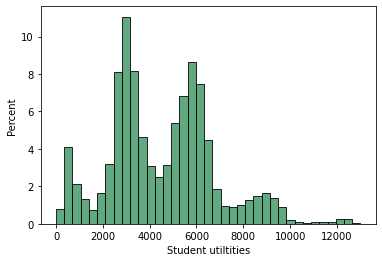

In [8]:
student_utilities = [s.get_utilities() for s in student_list]
sns.histplot(student_utilities, stat = 'percent', color = 'seagreen')
plt.xlabel("Student utiltities")

Text(0.5, 0, 'Course sizes')

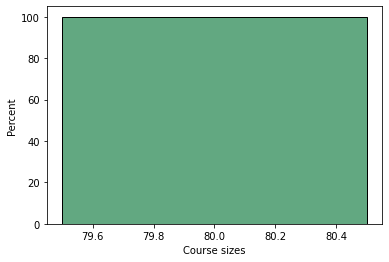

In [9]:
course_enroll_sizes = [len(c.student_enroll) for c in course_list]
sns.histplot(course_enroll_sizes, stat = 'percent', color = 'seagreen')
plt.xlabel("Course sizes")

## Sanity check

In [10]:
for c in course_list:
    for s in c.student_enroll:
        assert c.course_id in s.course_enroll

# Course Scheduling

There are $k = 12$ time slots. Assume that rooms are unlimited.

For each course-time assignment, find the number of conflicts among students and pick the one with the minimum conflicts.

There are $k^n$ possible course-time assignments. -> NP-hard

**Maximum-weight k-cut problem**

Min weight between components, but we want max conflicts between components

Higher conflicts $c$ -> lower weights $w$

$w = -c + \max(c)$

But weights need to be positive so add $\max(c)$ 

https://en.wikipedia.org/wiki/Minimum_k-cut

https://cstheory.stackexchange.com/questions/50321/max-k-cut-with-negative-edge-weights

https://math.mit.edu/~goemans/18434S06/multicuts-brian.pdf

https://neo4j.com/docs/graph-data-science/current/algorithms/approx-max-k-cut/

https://www.math.cmu.edu/~af1p/Texfiles/cuts.pdf

https://cs.gmu.edu/~lifei/teaching/cs684_spring12/multi-cut.pdf

https://www.geeksforgeeks.org/gomory-hu-tree-introduction/#

https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.flow.gomory_hu_tree.html

https://courses.engr.illinois.edu/cs598csc/sp2009/lectures/lecture_7.pdf

In [11]:
conflict_counts = defaultdict(int)

for s in student_list:
    for c1, c2 in combinations(sorted(s.course_enroll), 2):
        conflict_counts[(c1, c2)] += 1

print(f"number of edges: {len(conflict_counts)}")

number of edges: 3819


In [12]:
print(f"total number of conflicts: {sum(conflict_counts.values())}")

total number of conflicts: 7085422


In [45]:
graph = nx.Graph()
graph.add_weighted_edges_from([(c[0], c[1], n * (-1) + max(conflict_counts.values())) 
                               for c, n in conflict_counts.items()])
print(f"Number of nodes: {graph.number_of_nodes()}")
print(f"Number of edges: {graph.number_of_edges()}")

Number of nodes: 100
Number of edges: 3819


## Minimum-weight k-Cut Problem

Gomury-Hu approach for k-Cut$(G)$

1. Compute Gomury-Hu tree $T$ for $G$
2. Remove $k-1$ minimum weight (or lightest) edges from the Tree.
3. Return union of components obtained by above removal of edges.

Guarantee approximation ratio of $2 - \frac{2}{k}$

In [46]:
# nx.set_edge_attributes(graph, 1, "capacity")
T = nx.gomory_hu_tree(graph, capacity = 'weight')

In [47]:
# for node1, node2, data in T.edges(data = True):
#     print(f"({node1}, {node2}) with weight {data['weight']}")

(12, 55) with weight 3307043
(55, 94) with weight 3715678
(66, 94) with weight 3223311
(76, 94) with weight 3074321
(45, 94) with weight 3382907
(54, 94) with weight 3386489
(18, 94) with weight 3179601
(25, 94) with weight 3384320
(37, 94) with weight 3316702
(88, 94) with weight 3393571
(16, 94) with weight 2777026
(39, 94) with weight 3483571
(99, 94) with weight 3210974
(97, 94) with weight 3174311
(64, 94) with weight 3106923
(47, 94) with weight 3480784
(2, 94) with weight 3180038
(43, 94) with weight 3589119
(56, 94) with weight 3584387
(77, 94) with weight 3127545
(89, 94) with weight 3333920
(61, 94) with weight 3348731
(73, 94) with weight 3491001
(0, 94) with weight 3341989
(38, 94) with weight 3117121
(44, 94) with weight 3414152
(87, 94) with weight 3388556
(59, 94) with weight 3393498
(3, 94) with weight 3332947
(17, 94) with weight 3365287
(5, 94) with weight 3420126
(22, 94) with weight 3395450
(82, 94) with weight 3343404
(98, 94) with weight 3298252
(6, 94) with weigh

In [48]:
k = 12
min_weight_k_edges = sorted([e for e in T.edges(data = True)], 
                            key = lambda x: x[2]['weight'],
                            reverse = False)[: k - 1]
for node1, node2, data in min_weight_k_edges:
    print(f"({node1}, {node2}) with weight {data['weight']}")

(94, 40) with weight 2572040
(16, 94) with weight 2777026
(86, 94) with weight 2846411
(94, 93) with weight 2851806
(94, 50) with weight 2935643
(94, 63) with weight 2954837
(94, 62) with weight 2975687
(94, 53) with weight 2978521
(94, 34) with weight 2983489
(49, 94) with weight 3051224
(94, 28) with weight 3052722
(76, 94) with weight 3074321


In [49]:
# T.remove_edge(*edge)
T.remove_edges_from(min_weight_k_edges)
# U, V = list(nx.connected_components(T))

In [50]:
components = list(nx.connected_components(T))
print(f"Number of components: {len(components)}")
components

Number of components: 13


[{0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  29,
  30,
  31,
  32,
  33,
  35,
  36,
  37,
  38,
  39,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48,
  51,
  52,
  54,
  55,
  56,
  57,
  58,
  59,
  60,
  61,
  64,
  65,
  66,
  67,
  68,
  69,
  70,
  71,
  72,
  73,
  74,
  75,
  77,
  78,
  79,
  80,
  81,
  82,
  83,
  84,
  85,
  87,
  88,
  89,
  90,
  91,
  92,
  94,
  95,
  96,
  97,
  98,
  99},
 {76},
 {16},
 {86},
 {49},
 {53},
 {40},
 {34},
 {62},
 {63},
 {50},
 {28},
 {93}]

In [5]:
# cutset = set()
# U = components[0]
# V = components[2]
# for x, nbrs in ((n, graph[n]) for n in U):
#     cutset.update((x, y) for y in nbrs if y in V)
   
# print(f"size of cutset: {len(cutset)}")
# cutset

### Assign time to courses and resolve conflicts among students

In [ ]:
for t, c_list in enumerate(components):
    for c in list(c_list):
        course_list[c].set_time(t)

for s in student_list:
    s.determine_conflicts(course_list)

In [ ]:
student_list, course_list = resolve_conflicts(student_list, course_list)

In [ ]:
# for s in student_list:
#     s.get_enrollment_info()
# for c in course_list:
#     c.get_enrollment_info()

In [ ]:
student_utilities = [s.get_utilities() for s in student_list]
sns.histplot(student_utilities, stat = 'percent', color = 'seagreen')
plt.xlabel("Student utiltities")

In [ ]:
course_enroll_sizes = [len(c.student_enroll) for c in course_list]
sns.histplot(course_enroll_sizes, stat = 'percent', color = 'seagreen')
plt.xlabel("Course sizes")